In [1]:
import csv
from edgeDetection import *
import os
import matplotlib
# matplotlib.use('PS')
import matplotlib.pyplot as plt
import numpy as np
from readTabTxtFile import *
from calTempResolution import *
from trimmedTriggerTime import *
import seaborn as sn
import scipy
from caiman.source_extraction.cnmf.cnmf import load_CNMF
import csv
import pickle


2024-02-26 12:33:06.819967: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors  import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


In [2]:
directory = "/media/watson/UbuntuHDD/feng_Xin/Xin/Miniscope/5133307132023/reward_seeking/days_with_miniscope_recording/day26/15_18_15"

if not os.path.exists(directory+os.sep+'cellTraces_norm.txt'):
    cnmf_save = load_CNMF(directory + os.sep+'output_rescaled_cnmf_save.hdf5')
    cellTraces = cnmf_save.estimates.C
    valid_idx = cnmf_save.estimates.idx_components
    traces_sz = cellTraces.shape

    with open(directory + os.sep + "cellTraces.txt", 'w', newline="\n") as f:
        f_writer = csv.writer(f, delimiter='\t')
        for i in range(traces_sz[0]):
            f_writer.writerow(cellTraces[i, :])
    with open(directory+os.sep+"validIdx.txt", 'w', newline="\n") as f:
        f_writer = csv.writer(f, delimiter='\t')
        f_writer.writerow(valid_idx)

# for 49140 and 49142
# frameInput = 0
# lickTrigNum = 1
# pokeTrigNum = 2
# caTimeNum = 0
# pumpTrigNum = 4

# for 51331, 51332 and 51333
frameInput = 3
lickTrigNum = 2
pokeTrigNum = 0
caTimeNum = 3
pumpTrigNum = 1

validIdFile = "validIdx.txt"
cellTracesFile = "cellTraces_norm.txt"
pokeTriggerFile = "stim"+str(pokeTrigNum)+".txt"
lickTriggerFile = "stim"+str(lickTrigNum)+".txt"
pumpTriggerFile = "stim"+str(pumpTrigNum)+".txt"

caTimeFile = "stim"+str(caTimeNum)+".txt"
plotSavingFolder = 'Plots'
videoFrameNum = 1000

plotSavingFolder = 'Plots'
with open(directory + os.sep + 'frame_correction_pos.pickle','rb') as f:
    frame_correction = pickle.load(f)

def findClosestTimeIndex(t,tSeries):
    tDiff = [abs(t-i) for i in tSeries]
    nd_tDiff = np.array(tDiff)
    pos = np.argmin(nd_tDiff)
    return pos
def findClosestLickIndex(t1Series,refT,tSeries):
    tDiff = [[i-refT,i] for i in t1Series if i-refT>=0]
    nd_tDiff = np.array(tDiff)
    lick_pos = np.argmin(nd_tDiff[:,0])
    pos = findClosestTimeIndex(nd_tDiff[lick_pos,1],tSeries)
    return pos

def findAfterClosestIndex(t1Series,refT,tSeries):
    tDiff = [[i-refT,i] for i in t1Series if i-refT>=0]
    nd_tDiff = np.array(tDiff)
    lick_pos = np.argmin(nd_tDiff[:,0])
    pos = findClosestTimeIndex(nd_tDiff[lick_pos,1],tSeries)
    return pos

def findBeforeClosestIndex(t1Series,refT,tSeries):
    tDiff = [[i-refT,i] for i in t1Series if i-refT<=0]
    nd_tDiff = np.array(tDiff)
    lick_pos = np.argmax(nd_tDiff[:,0])
    pos = findClosestTimeIndex(nd_tDiff[lick_pos,1],tSeries)
    return pos

def findAllLickIndices(t1Series,refT,tSeries,window):
    pos=[]
    tDiff = [[i - tSeries[refT], i] for i in t1Series if i-tSeries[refT]>0 and i-tSeries[refT]-window*caFrameDur<0]
    nd_tDiff = np.array(tDiff)
    for i in nd_tDiff:
        pos_temp = findClosestTimeIndex(i[1],tSeries)
        pos.append(pos_temp)
    return pos

def interpolateNaN(x):
    loc = np.argwhere(np.isnan(x))
    for i in loc:
        x[i[0]] = (x[i[0]-1] + x[i[0]+1])/2
    return x
with open(directory+os.sep+cellTracesFile, "r", newline="\n") as readFile:
    data_reader = readFile.readlines()
# with open(directory+os.sep+validIdFile, "r", newline="") as readFile:
#     id_reader = readFile.readlines()
# with open(directory+os.sep+triggerFile, "r", newline="") as readFile:
#     trig_reader = readFile.readlines()
# with open(directory+os.sep+caTimeFile, "r", newline="") as readFile:
#     caTime_reader = readFile.readlines()

caData = readTabTxtFile(directory+os.sep+cellTracesFile, 'float')
valid_idx = readTabTxtFile(directory+os.sep+validIdFile, 'int')
pokeTrigTime = readTabTxtFile(directory+os.sep+pokeTriggerFile, 'float')
lickTrigTime = readTabTxtFile(directory+os.sep+lickTriggerFile, 'float')
caTime = readTabTxtFile(directory+os.sep+caTimeFile, 'float')
caFrameDur = calTempResolution(caTime)
pumpTrigTime = readTabTxtFile(directory+os.sep+pumpTriggerFile, 'float')

# valid_idx = [int(i) for i in id_reader[0].strip().split("\t")]
# caTime = [float(i) for i in caTime_reader[0].strip().split("\t")]
# trigTime = [float(i) for i in trig_reader[0].strip().split("\t")]
numVideoShift = 0
preTrigWindow_poke = -15
postTrigWindow_poke = 15
preTrigWindow_lick = -15
postTrigWindow_lick = 15
len_window = postTrigWindow_poke-preTrigWindow_poke
trimmed_pokeTrigTime = trimmedTriggerTime(pokeTrigTime,caTime,videoFrameNum*numVideoShift,-1)
trimmed_lickTrigTime = trimmedTriggerTime(lickTrigTime,caTime,videoFrameNum*numVideoShift,-1)
trimmed_pumpTrigTime = trimmedTriggerTime(pumpTrigTime,caTime,videoFrameNum*numVideoShift,-1)

# numTrig = len(trimmed_pokeTrigTime)
numTrig_pump = len(trimmed_pumpTrigTime)
numTrig_poke = len(trimmed_pokeTrigTime)
numTrig_lick = len(trimmed_lickTrigTime)

numData = len(caData)
numAnalysisWindow = -1*preTrigWindow_poke+postTrigWindow_poke
pokeTimeAdj = 0.03

# zscore_ca_good = np.zeros((len(valid_idx),numTrig_pump,len_window))
# zscore_ca_poke = np.zeros((len(valid_idx),1,len_window))
# zscore_ca_lick = np.zeros((len(valid_idx),1,len_window))

zscore_ca_good = np.array([])
zscore_ca_poke = np.array([])
zscore_ca_lick = np.array([])
zscore_ca_noTrig = np.array([])

In [3]:
ca_trace_isTrig = np.zeros(len(caTime))

for trig_id in range(numTrig_poke):
    try:

        ca_pos_temp_poke = findClosestTimeIndex(trimmed_pokeTrigTime[trig_id], caTime)
        ca_pos_poke = ca_pos_temp_poke - videoFrameNum * numVideoShift
        ca_trace_isTrig[ca_pos_poke + preTrigWindow_poke: ca_pos_poke + postTrigWindow_poke] = 1
        
    except:
        print("Analysis window is outside ca2+ data size")
for trig_id in range(numTrig_lick):
    try:

        ca_pos_temp_lick = findClosestTimeIndex(trimmed_pokeLickTime[trig_id], caTime)
        ca_pos_lick = ca_pos_temp_lick - videoFrameNum * numVideoShift
        ca_trace_isTrig[ca_pos_lick + preTrigWindow_lick: ca_pos_lick + postTrigWindow_lick] = 1
        
    except:
        print("Analysis window is outside ca2+ data size")

Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ data size
Analysis window is outside ca2+ da

In [4]:
skip_id = []
for i in range(len(valid_idx)):
    ca_trace = [float(k) for k in data_reader[valid_idx[i]].strip().split("\t")]
    if frame_correction:
        ca_trace_corrected = ca_trace[0:frame_correction[0]+1]+ [float('NaN')]*frame_correction[1] + ca_trace[frame_correction[0]+1:-1]
    else:
        ca_trace_corrected = ca_trace

    ca_raw_traces_poke = []
    ca_raw_traces_lick = []
    ca_raw_traces_noTrig = []

    for trig_id in range(numTrig_pump): 
        if trig_id in skip_id:
            continue
        else:
            try:
                ca_pos_temp_pump = findClosestTimeIndex(trimmed_pumpTrigTime[trig_id], caTime)
                ca_pos_temp_poke = findBeforeClosestIndex(trimmed_pokeTrigTime, trimmed_pumpTrigTime[trig_id], caTime)
                ca_pos_temp_lick = findAfterClosestIndex(trimmed_lickTrigTime, caTime[ca_pos_temp_poke], caTime)
    
                ca_pos_poke = ca_pos_temp_poke - videoFrameNum * numVideoShift
                ca_pos_lick = ca_pos_temp_lick - videoFrameNum * numVideoShift
                ca_pos_pump = ca_pos_temp_pump - videoFrameNum * numVideoShift
    
                plot_ca_poke = interpolateNaN(ca_trace_corrected[ca_pos_poke + preTrigWindow_poke: ca_pos_poke + postTrigWindow_poke])
                plot_ca_lick = interpolateNaN(ca_trace_corrected[ca_pos_lick + preTrigWindow_lick: ca_pos_lick + postTrigWindow_lick])
    
                if np.any(np.isnan(scipy.stats.zscore(plot_ca_poke))) or np.any(np.isnan(scipy.stats.zscore(plot_ca_lick))):
                    print('there is an NaN','current i is:',i,'current trig id is:',trig_id,sep='')
                    skip_id.append(trig_id)
                    print(skip_id)
                    continue
                else:
                    print("passed")
            except:
                print("Analysis window is outside ca2+ data size")
   

passed
passed
there is an NaNcurrent i is:0current trig id is:2
[2]
there is an NaNcurrent i is:0current trig id is:3
[2, 3]
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
there is an NaNcurrent i is:0current trig id is:14
[2, 3, 14]
passed
there is an NaNcurrent i is:0current trig id is:16
[2, 3, 14, 16]
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passed
passe

In [5]:

for i in range(len(valid_idx)):
    ca_trace = [float(k) for k in data_reader[valid_idx[i]].strip().split("\t")]
    if frame_correction:
        ca_trace_corrected = ca_trace[0:frame_correction[0]+1]+ [float('NaN')]*frame_correction[1] + ca_trace[frame_correction[0]+1:-1]
    else:
        ca_trace_corrected = ca_trace

    ca_raw_traces_poke = []
    ca_raw_traces_lick = []
    ca_raw_traces_noTrig = []

    for trig_id in range(numTrig_pump): 
        if trig_id in skip_id:
            continue
        else:
            try:
                ca_pos_temp_pump = findClosestTimeIndex(trimmed_pumpTrigTime[trig_id], caTime)
                ca_pos_temp_poke = findBeforeClosestIndex(trimmed_pokeTrigTime, trimmed_pumpTrigTime[trig_id], caTime)
                ca_pos_temp_lick = findAfterClosestIndex(trimmed_lickTrigTime, caTime[ca_pos_temp_poke], caTime)
    
                ca_pos_poke = ca_pos_temp_poke - videoFrameNum * numVideoShift
                ca_pos_lick = ca_pos_temp_lick - videoFrameNum * numVideoShift
                ca_pos_pump = ca_pos_temp_pump - videoFrameNum * numVideoShift
                print(ca_pos_lick-ca_pos_poke)
    
                plot_ca_poke = interpolateNaN(ca_trace_corrected[ca_pos_poke + preTrigWindow_poke: ca_pos_poke + postTrigWindow_poke])
                plot_ca_lick = interpolateNaN(ca_trace_corrected[ca_pos_lick + preTrigWindow_lick: ca_pos_lick + postTrigWindow_lick])
    
                if np.any(np.isnan(scipy.stats.zscore(plot_ca_poke))) or np.any(np.isnan(scipy.stats.zscore(plot_ca_lick))):
                    print('there is an NaN','current i is:',i,'current trig id is:',trig_id,sep='')
                    skip_id.append(trig_id)
                    print(skip_id)
                    continue
                else:
                    if len(plot_ca_poke)==numAnalysisWindow:
                        ca_raw_traces_poke.append(plot_ca_poke)
        
                    if len(plot_ca_lick)==numAnalysisWindow:
                        ca_raw_traces_lick.append(plot_ca_lick)
            except:
                print("Analysis window is outside ca2+ data size")
    if i == 0:
        zscore_ca_poke = scipy.stats.zscore(ca_raw_traces_poke,axis=1,nan_policy='omit')
        zscore_ca_poke = np.expand_dims(zscore_ca_poke,axis=0)
        zscore_ca_lick = scipy.stats.zscore(ca_raw_traces_lick,axis=1,nan_policy='omit')
        zscore_ca_lick = np.expand_dims(zscore_ca_lick,axis=0)
    
    else:
        zscore_ca_poke = np.append(zscore_ca_poke,np.expand_dims(scipy.stats.zscore(ca_raw_traces_poke,axis=1,nan_policy='omit'),axis=0),axis=0)
        zscore_ca_lick = np.append(zscore_ca_lick,np.expand_dims(scipy.stats.zscore(ca_raw_traces_lick,axis=1,nan_policy='omit'),axis=0),axis=0)


    i_noTrig = 0
    bool_isTrig = np.array(ca_trace_isTrig,dtype='bool')
    while i_noTrig<len(bool_isTrig)-len_window:
        
        if np.any(bool_isTrig[i_noTrig:i_noTrig+len_window]):
            i_noTrig = i_noTrig+1
        else:
            plot_ca = interpolateNaN(ca_trace_corrected[i_noTrig: i_noTrig + len_window])
            
            if np.any(np.isnan(scipy.stats.zscore(plot_ca))):
                # print(i_noTrig)
                ca_trace_isTrig[i_noTrig: i_noTrig + len_window] = 1
                i_noTrig = i_noTrig + len_window
            else:
                
                # ca_raw_traces_noTrig.append(plot_ca)
                i_noTrig = i_noTrig + len_window
    # if np.any(np.isnan(scipy.stats.zscore(ca_raw_traces_noTrig,axis=1,nan_policy='omit'))):
    #     continue
    # else:
    #     if i==0:
            
    #         zscore_ca_noTrig = scipy.stats.zscore(ca_raw_traces_noTrig,axis=1,nan_policy='omit')
    #         zscore_ca_noTrig = np.expand_dims(zscore_ca_noTrig,axis=0)
    #     else:
    #         zscore_ca_noTrig = np.append(zscore_ca_noTrig,np.expand_dims(scipy.stats.zscore(ca_raw_traces_noTrig,axis=1,nan_policy='omit'),axis=0),axis=0)


41
42
35
41
40
40
52
43
39
41
41
33
42
42
34
37
37
89
32
48
48
39
45
38
40
40
40
34
35
35
37
38
70
36
36
41
32
677
31
31
36
30
37
37
213
55
41
42
35
41
40
40
52
43
39
41
41
33
42
42
34
37
37
89
32
48
48
39
45
38
40
40
40
34
35
35
37
38
70
36
36
41
32
677
31
31
36
30
37
37
213
55
41
42
35
41
40
40
52
43
39
41
41
33
42
42
34
37
37
89
32
48
48
39
45
38
40
40
40
34
35
35
37
38
70
36
36
41
32
677
31
31
36
30
37
37
213
55
41
42
35
41
40
40
52
43
39
41
41
33
42
42
34
37
37
89
32
48
48
39
45
38
40
40
40
34
35
35
37
38
70
36
36
41
32
677
31
31
36
30
37
37
213
55
41
42
35
41
40
40
52
43
39
41
41
33
42
42
34
37
37
89
32
48
48
39
45
38
40
40
40
34
35
35
37
38
70
36
36
41
32
677
31
31
36
30
37
37
213
55
41
42
35
41
40
40
52
43
39
41
41
33
42
42
34
37
37
89
32
48
48
39
45
38
40
40
40
34
35
35
37
38
70
36
36
41
32
677
31
31
36
30
37
37
213
55
41
42
35
41
40
40
52
43
39
41
41
33
42
42
34
37
37
89
32
48
48
39
45
38
40
40
40
34
35
35
37
38
70
36
36
41
32
677
31
31
36
30
37
37
213
55
41
42
35
41
40
40
52

In [6]:
for i in range(len(valid_idx)):
    ca_trace = [float(k) for k in data_reader[valid_idx[i]].strip().split("\t")]
    if frame_correction:
        ca_trace_corrected = ca_trace[0:frame_correction[0]+1]+ [float('NaN')]*frame_correction[1] + ca_trace[frame_correction[0]+1:-1]
    else:
        ca_trace_corrected = ca_trace

    ca_raw_traces_noTrig = []
    
    i_noTrig = 0
    bool_isTrig = np.array(ca_trace_isTrig,dtype='bool')
    while i_noTrig<len(bool_isTrig)-len_window:
        if np.any(bool_isTrig[i_noTrig:i_noTrig+len_window]):
            i_noTrig = i_noTrig+1
        else:
            plot_ca = interpolateNaN(ca_trace_corrected[i_noTrig: i_noTrig + len_window])

            ca_raw_traces_noTrig.append(plot_ca)
            i_noTrig = i_noTrig + len_window
    # if np.any(np.isnan(scipy.stats.zscore(ca_raw_traces_noTrig,axis=1,nan_policy='omit'))):
    #     print(i)
    #     continue
    # else:
    if i==0:
        
        zscore_ca_noTrig = scipy.stats.zscore(ca_raw_traces_noTrig,axis=1,nan_policy='omit')
        zscore_ca_noTrig = np.expand_dims(zscore_ca_noTrig,axis=0)
    else:
        zscore_ca_noTrig = np.append(zscore_ca_noTrig,np.expand_dims(scipy.stats.zscore(ca_raw_traces_noTrig,axis=1,nan_policy='omit'),axis=0),axis=0)


In [7]:
zscore_poke = np.transpose(zscore_ca_poke,(1,0,2))
zscore_lick = np.transpose(zscore_ca_lick,(1,0,2))
zscore_noTrig = np.transpose(zscore_ca_noTrig,(1,0,2))

In [53]:
dummy,zscore_noTrig_test_ind = train_test_split(np.arange(0,zscore_noTrig.shape[0]),test_size=0.025)

In [54]:
zscore_noTrig_test = zscore_noTrig[zscore_noTrig_test_ind,:]

In [ ]:
plot_trial = 6
plt.figure()
for i in range(31):
    ax = plt.subplot(31,1,i+1)
    ax.plot(zscore_poke[plot_trial,i,:])
    ax.set_axis_off()
    # ax_1 = plt.subplot(31,1,i+1)
    ax.plot(zscore_lick[plot_trial,i,:])
    # ax_1.set_axis_off()
    
    
    

In [131]:
from sklearn.decomposition import PCA
n_pca = 20
n_used_pca = 15
pca_poke = PCA(n_components=n_pca)
pca_lick = PCA(n_components=n_pca)
pca_noTrig = PCA(n_components=n_pca)
size_poke = zscore_poke.shape
size_lick = zscore_lick.shape
size_noTrig = zscore_noTrig_test.shape


In [132]:
poke_pca_values = np.zeros((size_poke[0],size_poke[1],n_pca))
lick_pca_values = np.zeros((size_lick[0],size_lick[1],n_pca))
noTrig_pca_values = np.zeros((size_noTrig[0],size_noTrig[1],n_pca))


In [133]:
zscore_poke.shape

(46, 31, 30)

In [134]:
for i in range(size_poke[0]):
    poke_pca_values[i,:] = pca_poke.fit_transform(zscore_poke[i,:,:])

for i in range(size_lick[0]):
    lick_pca_values[i,:] = pca_lick.fit_transform(zscore_lick[i,:,:])
for i in range(size_noTrig[0]):
    noTrig_pca_values[i,:] = pca_noTrig.fit_transform(zscore_noTrig_test[i,:,:])
    
    
# poke_pca_values = pca_poke.fit_transform(np.reshape(zscore_poke,(zscore_poke.shape[0],size[1]*size[2])))
# lick_pca_values = pca_lick.fit_transform(np.reshape(zscore_lick,(zscore_lick.shape[0],size[1]*size[2])))
# noTrig_pca_values = pca_noTrig.fit_transform(np.reshape(zscore_noTrig,(zscore_noTrig.shape[0],size[1]*size[2])))



In [90]:
pca_poke.explained_variance_ratio_.cumsum()

array([0.45660492, 0.63808248, 0.74964485, 0.81589338, 0.86894144,
       0.89351089, 0.91404396, 0.92998159, 0.94370608, 0.95677797,
       0.9673452 , 0.97475053, 0.98041974, 0.98478669, 0.98866139,
       0.9917804 , 0.99458476, 0.99674673, 0.99769318, 0.99855234])

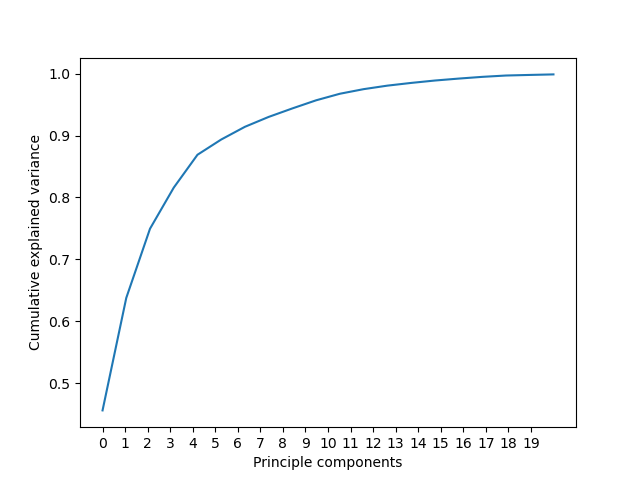

In [91]:
plt.figure()
plt.plot(np.linspace(0,n_pca,n_pca),pca_poke.explained_variance_ratio_.cumsum())
plt.xticks(np.arange(0,20,1))
plt.xlabel('Principle components')
plt.ylabel("Cumulative explained variance")
plt.savefig(directory+os.sep+plotSavingFolder+os.sep+'Explained_variance.eps',format='eps')


In [135]:
poke_pca_values_used = np.reshape(poke_pca_values[:,:,0:n_used_pca],(size_poke[0],size_poke[1]*n_used_pca))
lick_pca_values_used = np.reshape(lick_pca_values[:,:,0:n_used_pca],(size_lick[0],size_lick[1]*n_used_pca))
noTrig_pca_values_used = np.reshape(noTrig_pca_values[:,:,0:n_used_pca],(size_noTrig[0],size_noTrig[1]*n_used_pca))


In [102]:
import umap
umap_n = 3
poke_umap = umap.UMAP(min_dist=0.6,n_components=umap_n,n_neighbors=50,metric = 'cosine',init='spectral')
lick_umap = umap.UMAP(min_dist=0.6,n_components=umap_n,n_neighbors=50,metric = 'cosine',init='spectral')
noTrig_umap = umap.UMAP(min_dist=0.6,n_components=umap_n,n_neighbors=50,metric = 'cosine',init='spectral')

poke_umap_values = np.zeros((size_poke[0],umap_n))
lick_umap_values = np.zeros((size_lick[0],umap_n))
noTrig_umap_values = np.zeros((size_noTrig[0],umap_n))


In [136]:
poke_umap_values = poke_umap.fit_transform(np.reshape(zscore_poke[:,:,0:n_used_pca],(size_poke[0],size_poke[1]*n_used_pca)))
lick_umap_values= lick_umap.fit_transform(np.reshape(zscore_lick[:,:,0:n_used_pca],(size_lick[0],size_lick[1]*n_used_pca)))
noTrig_umap_values = noTrig_umap.fit_transform(np.reshape(zscore_noTrig_test[:,:,0:n_used_pca],(size_noTrig[0],size_noTrig[1]*n_used_pca)))

/home/watson/anaconda3/envs/caiman/lib/python3.11/site-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/watson/anaconda3/envs/caiman/lib/python3.11/site-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [ ]:
# from sklearn.manifold import TSNE
# poke_tsne_values= TSNE().fit_transform(np.reshape(zscore_poke,(zscore_poke.shape[0],size[1]*size[2])))
# lick_tsne_values= TSNE().fit_transform(np.reshape(zscore_lick,(zscore_lick.shape[0],size[1]*size[2])))
# noTrig_tsne_values= TSNE().fit_transform(np.reshape(zscore_noTrig,(zscore_noTrig.shape[0],size[1]*size[2])))


/tmp/ipykernel_3172396/919242038.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(poke_pca_values_used[:, 0], poke_pca_values_used[:, 1],poke_pca_values_used[:, 1],cmap=plt.cm.viridis, edgecolor="k")
/tmp/ipykernel_3172396/919242038.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(lick_pca_values_used[:, 0], lick_pca_values_used[:, 1],lick_pca_values_used[:, 2],cmap=plt.cm.viridis, edgecolor="r")
/tmp/ipykernel_3172396/919242038.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(noTrig_pca_values_used[:, 0], noTrig_pca_values_used[:, 1], noTrig_pca_values_used[:, 1],cmap=plt.cm.viridis, edgecolor="g")


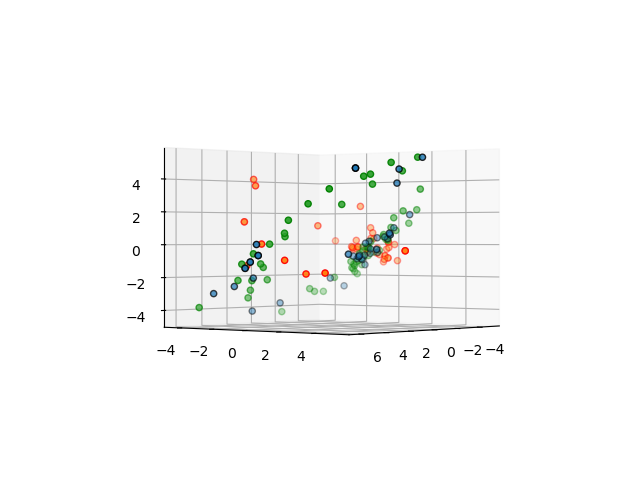

In [86]:
fig = plt.figure()

ax = plt.subplot(111,projection='3d')
ax.view_init(elev=0, azim=40,roll=0)

ax.scatter(poke_pca_values_used[:, 0], poke_pca_values_used[:, 1],poke_pca_values_used[:, 1],cmap=plt.cm.viridis, edgecolor="k")
ax.scatter(lick_pca_values_used[:, 0], lick_pca_values_used[:, 1],lick_pca_values_used[:, 2],cmap=plt.cm.viridis, edgecolor="r")
ax.scatter(noTrig_pca_values_used[:, 0], noTrig_pca_values_used[:, 1], noTrig_pca_values_used[:, 1],cmap=plt.cm.viridis, edgecolor="g")


/tmp/ipykernel_3172396/4254588920.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(poke_umap_values[:, 0], poke_umap_values[:, 1], poke_umap_values[:, 2],cmap=plt.cm.viridis, edgecolor="k")
/tmp/ipykernel_3172396/4254588920.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(lick_umap_values[:, 0], lick_umap_values[:, 1], lick_umap_values[:, 2],cmap=plt.cm.viridis, edgecolor="r")
/tmp/ipykernel_3172396/4254588920.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(noTrig_umap_values[:, 0], noTrig_umap_values[:, 1], noTrig_umap_values[:, 2], cmap=plt.cm.viridis, edgecolor="g")
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


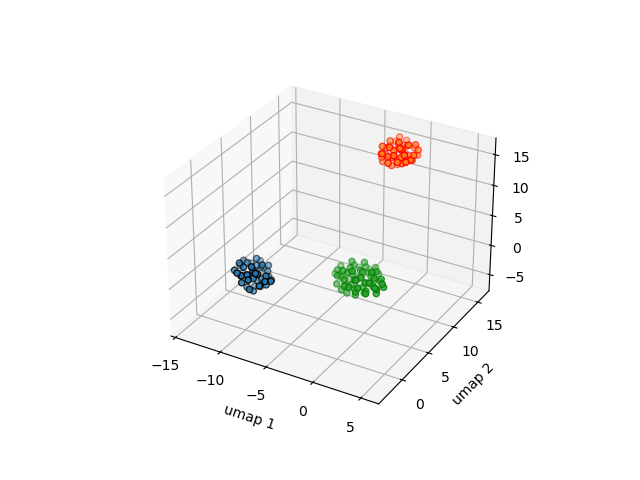

In [142]:
plt.figure()
ax = plt.subplot(111,projection='3d')
ax.scatter(poke_umap_values[:, 0], poke_umap_values[:, 1], poke_umap_values[:, 2],cmap=plt.cm.viridis, edgecolor="k")
ax.scatter(lick_umap_values[:, 0], lick_umap_values[:, 1], lick_umap_values[:, 2],cmap=plt.cm.viridis, edgecolor="r")
ax.scatter(noTrig_umap_values[:, 0], noTrig_umap_values[:, 1], noTrig_umap_values[:, 2], cmap=plt.cm.viridis, edgecolor="g")
plt.xlabel('umap 1')
plt.ylabel('umap 2')
plt.savefig(directory+os.sep+plotSavingFolder+os.sep+'UMAP clusters.eps',format='eps')

In [ ]:
# plt.figure()
# ax = plt.subplot(111)
# ax.scatter(poke_tsne_values[:, 0], poke_tsne_values[:, 1], cmap=plt.cm.viridis, edgecolor="k")
# ax.scatter(lick_tsne_values[:, 0], lick_tsne_values[:, 1], cmap=plt.cm.viridis, edgecolor="r")
# ax.scatter(noTrig_tsne_values[:, 0], noTrig_tsne_values[:, 1], cmap=plt.cm.viridis, edgecolor="g")


In [ ]:
# import matplotlib
# # matplotlib.use('PS')
# import matplotlib.pyplot as plt
# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)

# ax.scatter(poke_pca_values[:, 0], poke_pca_values[:, 1], poke_pca_values[:, 2], cmap=plt.cm.nipy_spectral, edgecolor="k")
# ax.scatter(lick_pca_values[:, 0], lick_pca_values[:, 1], lick_pca_values[:, 2], cmap=plt.cm.nipy_spectral, edgecolor="r")
# ax.scatter(noTrig_pca_values[:, 0], noTrig_pca_values[:, 1], noTrig_pca_values[:, 2], cmap=plt.cm.nipy_spectral, edgecolor="c")

In [ ]:
# poke = np.reshape(zscore_poke,(zscore_poke.shape[0],size[1]*size[2]))
# lick = np.reshape(zscore_lick,(zscore_lick.shape[0],size[1]*size[2]))
# noTrig = np.reshape(zscore_noTrig,(zscore_noTrig.shape[0],size[1]*size[2]))

In [125]:
X = np.concatenate((noTrig_pca_values_used, lick_pca_values_used, poke_pca_values_used),axis=0)
Y = np.concatenate((np.zeros(noTrig_pca_values_used.shape[0]),np.ones(lick_pca_values_used.shape[0]),np.ones(poke_pca_values_used.shape[0])*2),axis=0)

In [126]:
x_train, x_test, y_train, y_test=train_test_split(X,Y,test_size=0.3,stratify = Y)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5,test_size=0.3)
sss.get_n_splits(x_train,y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'C': [0.01,0.1,1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['poly']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
    
 ]
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid,cv=sss)

In [127]:
knn= KNeighborsClassifier(n_neighbors=3)
clf = svm.SVC()
rf_model = RandomForestClassifier()
xgb_model = xgb.XGBClassifier()

In [128]:
clf.fit(x_train,y_train)

SVC()

In [129]:
clf.score(x_test,y_test)

0.7608695652173914

In [143]:
clf.predict(x_test)

array([2., 0., 0., 0., 0., 1., 1., 0., 1., 2., 2., 0., 0., 0., 1., 2., 1.,
       1., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 2., 0., 1., 2., 2., 1., 2., 2.])

In [78]:
y_test

array([0., 1., 0., 0., 0., 0., 0., 1., 2., 1., 1., 1., 0., 0., 2., 0., 0.,
       2., 2., 0., 2., 0., 1., 0., 1., 1., 1., 2., 1., 0., 2., 2., 2., 2.,
       1., 1., 0., 1., 2., 1., 2., 0., 2., 2., 0., 0.])

In [ ]:
from sklearn.model_selection import permutation_test_score
score, permutation_scores, pvalue =permutation_test_score(estimator=clf,X=x_train,y=y_train,cv=sss,n_permutations=100)

In [ ]:
plt.hist(permutation_scores,bins=20)

In [ ]:
accuracies=cross_val_score(estimator=clf,X=x_train,y=y_train,cv=sss)

In [ ]:
score